In [1]:
pip install torchio monai

  Using cached monai-1.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached Deprecated-1.2.18-py2.py3-none-any.whl.metadata (5.7 kB)
  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached humanize-4.12.3-py3-none-any.whl.metadata (7.8 kB)
  Using cached nibabel-5.3.2-py3-none-any.whl.metadata (9.1 kB)
  Using cached simpleitk-2.5.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (7.2 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached typer-0.16.0-py3-none-any.whl.metadata (15 kB)
  Using cached torch-2.6.0-cp310-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata 

In [1]:
import torch
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

mps


In [2]:
from pathlib import Path

path = '/Users/matthewhalvorsen/Desktop/Desktop - Matthew’s MacBook Pro (2)/Grad School /Summer 2025/CPE646/Final Project/archive'
dir = Path(path)

print('File in directory:', )
for item in dir.iterdir():
  print(item)

File in directory:
/Users/matthewhalvorsen/Desktop/Desktop - Matthew’s MacBook Pro (2)/Grad School /Summer 2025/CPE646/Final Project/archive/BraTS2021_00495.tar
/Users/matthewhalvorsen/Desktop/Desktop - Matthew’s MacBook Pro (2)/Grad School /Summer 2025/CPE646/Final Project/archive/BraTS2021_Training_Data.tar
/Users/matthewhalvorsen/Desktop/Desktop - Matthew’s MacBook Pro (2)/Grad School /Summer 2025/CPE646/Final Project/archive/BraTS2021_00621.tar


Extract Data from the Training Set

In [3]:
import tarfile
from pathlib import Path

# Path to the downloaded .tar file
tar_path = Path("/Users/matthewhalvorsen/Desktop/Desktop - Matthew’s MacBook Pro (2)/Grad School /Summer 2025/CPE646/Final Project/archive/BraTS2021_Training_Data.tar")

# Define extraction destination (can be anywhere you'd like)
extract_path = Path("'/Users/matthewhalvorsen/Desktop/Desktop - Matthew’s MacBook Pro (2)/Grad School /Summer 2025/CPE646/Final Project/Extracted Files'")

# Extract the archive
print(f"Extracting {tar_path.name} to {extract_path} ...")
with tarfile.open(tar_path) as tar:
    tar.extractall(path=extract_path)

print("Extraction complete")

Extracting BraTS2021_Training_Data.tar to '/Users/matthewhalvorsen/Desktop/Desktop - Matthew’s MacBook Pro (2)/Grad School /Summer 2025/CPE646/Final Project/Extracted Files' ...
Extraction complete


Check contents of extracted path

In [4]:
for subject_dir in extract_path.iterdir():
    if subject_dir.is_dir():
        print(f"{subject_dir.name}: {[f.name for f in subject_dir.glob('*.nii.gz')]}")
        break

BraTS2021_00639: ['BraTS2021_00639_t1ce.nii.gz', 'BraTS2021_00639_t1.nii.gz', 'BraTS2021_00639_flair.nii.gz', 'BraTS2021_00639_seg.nii.gz', 'BraTS2021_00639_t2.nii.gz']


Visualize Data and shape

MRI Modalities:
FLAIR shape: (240, 240, 155)
T1 shape: (240, 240, 155)
T1CE shape: (240, 240, 155)
T2 shape: (240, 240, 155)
Segmentation shape: (240, 240, 155)


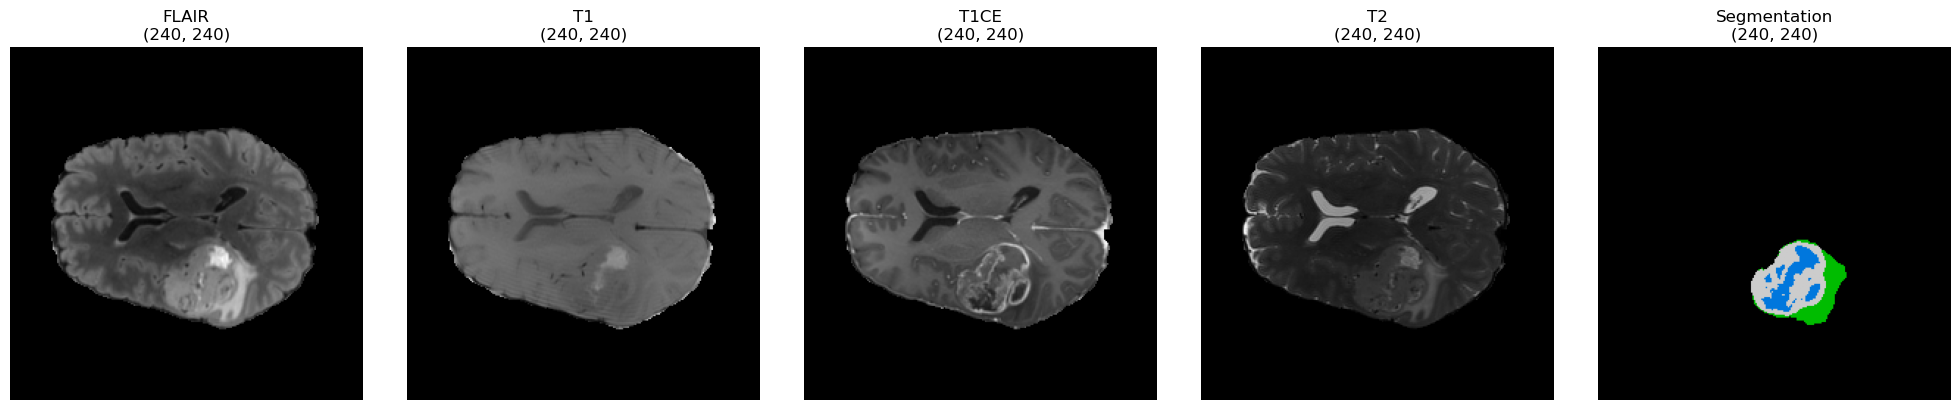

In [5]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set path to subject folder
subject_id = "BraTS2021_00072"
subject_path = extract_path / subject_id

# Load and convert each modality to a numpy array
modalities = ['flair', 't1', 't1ce', 't2']
images_np = {}  # to store each image array

print("MRI Modalities:")
for mod in modalities:
    img_nii = nib.load(subject_path / f"{subject_id}_{mod}.nii.gz")
    img_np = img_nii.get_fdata()
    img_np = (img_np - np.mean(img_np)) / np.std(img_np)  # Normalize
    images_np[mod] = img_np
    print(f"{mod.upper()} shape: {img_np.shape}")

# Load and convert segmentation mask
seg_np = nib.load(subject_path / f"{subject_id}_seg.nii.gz").get_fdata().astype(np.uint8)
print(f"Segmentation shape: {seg_np.shape}")

# Choose a middle axial slice
slice_idx = seg_np.shape[2] // 2

# Display each image slice
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, mod in enumerate(modalities):
    axs[i].imshow(images_np[mod][:, :, slice_idx], cmap='gray')
    axs[i].set_title(f"{mod.upper()}\n{images_np[mod][:, :, slice_idx].shape}")
    axs[i].axis('off')

# Display segmentation mask
axs[4].imshow(seg_np[:, :, slice_idx], cmap='nipy_spectral')
axs[4].set_title(f"Segmentation\n{seg_np[:, :, slice_idx].shape}")
axs[4].axis('off')

plt.tight_layout()
plt.show()

Visualize images from axial, coronal and sagittal views

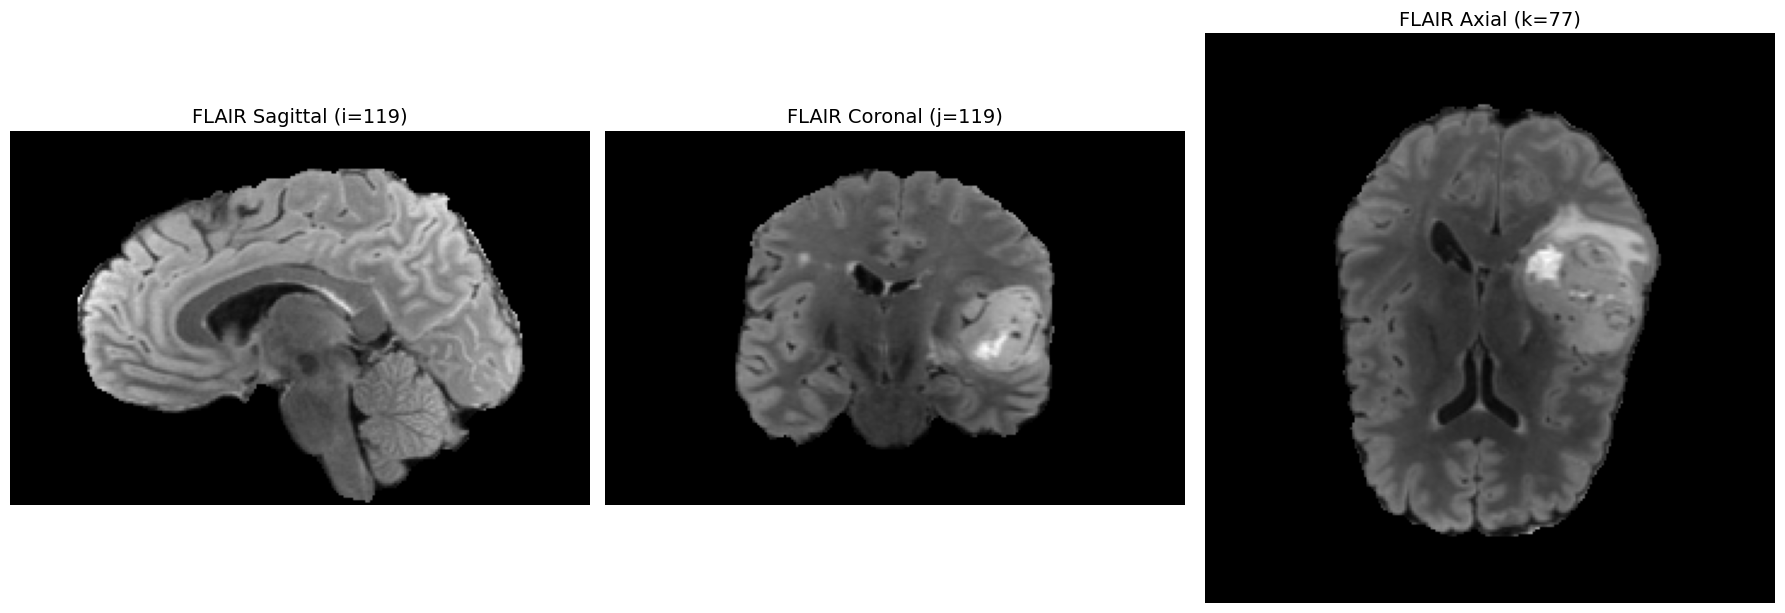

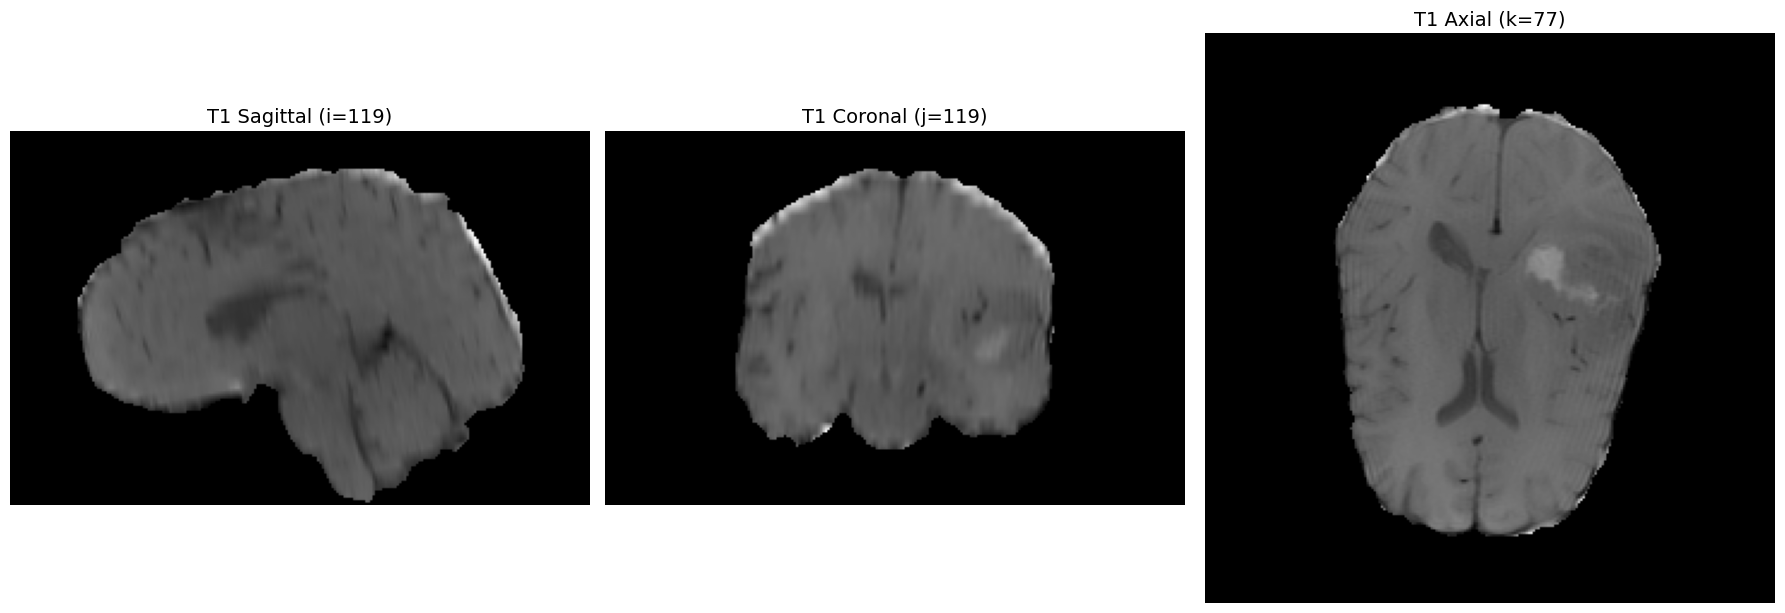

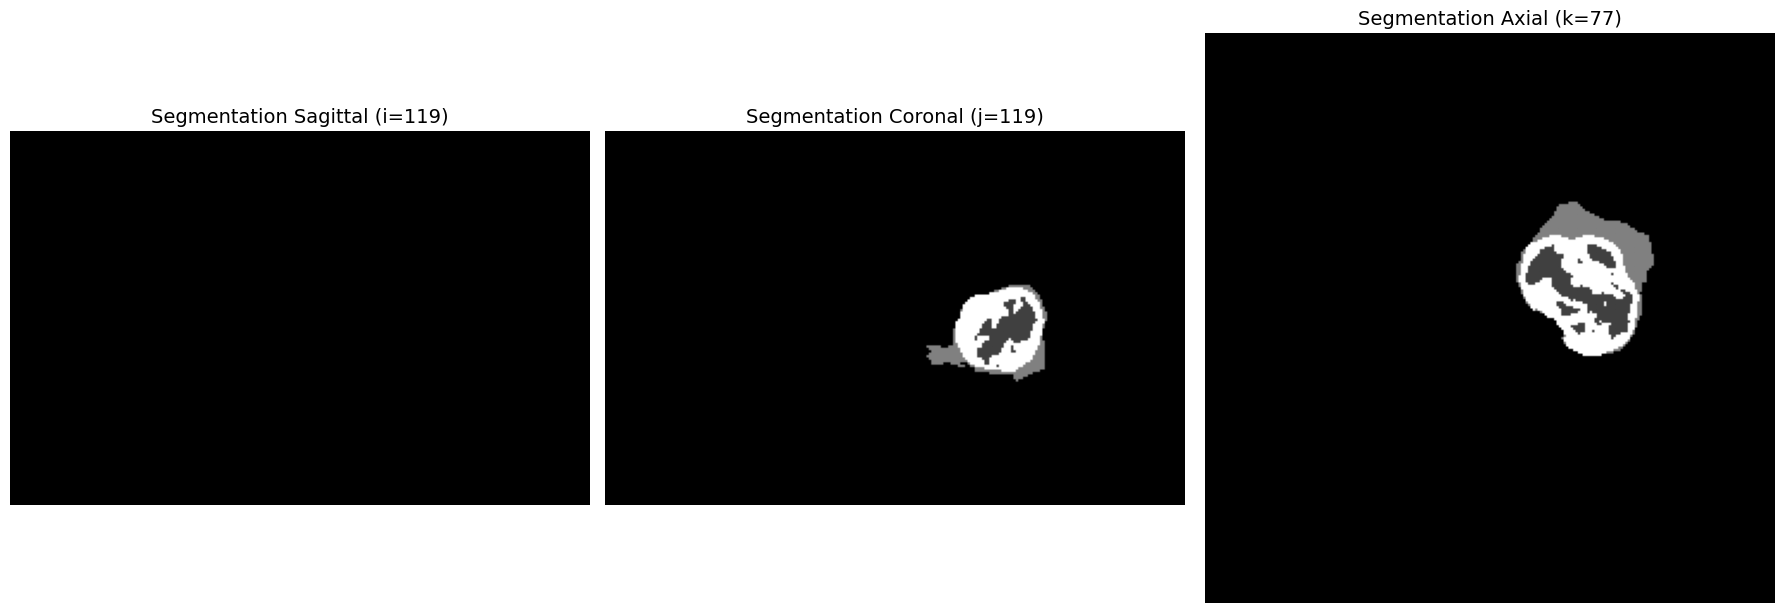

In [6]:
import matplotlib.pyplot as plt

def visualize_orthogonal_slices(volume, title=""):
    """
    Visualizes sagittal, coronal, and axial slices from a 3D medical image.

    Parameters:
        volume (numpy.ndarray): A 3D array (e.g., shape: (240, 240, 155))
    """
    # Ensure input is 3D
    assert volume.ndim == 3, "Input volume must be 3D."

    # Get center coordinates
    n_i, n_j, n_k = volume.shape
    i = (n_i - 1) // 2
    j = (n_j - 1) // 2
    k = (n_k - 1) // 2

    # Extract slices
    sagittal = volume[i, :, :]     # YZ plane
    coronal = volume[:, j, :]      # XZ plane
    axial = volume[:, :, k]        # XY plane

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(sagittal.T, cmap="gray", origin="lower")
    axes[0].set_title(f"{title} Sagittal (i={i})", fontsize=14)
    axes[0].axis("off")

    axes[1].imshow(coronal.T, cmap="gray", origin="lower")
    axes[1].set_title(f"{title} Coronal (j={j})", fontsize=14)
    axes[1].axis("off")

    axes[2].imshow(axial.T, cmap="gray", origin="lower")
    axes[2].set_title(f"{title} Axial (k={k})", fontsize=14)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_orthogonal_slices(images_np["flair"], title="FLAIR")
visualize_orthogonal_slices(images_np["t1"], title="T1")
visualize_orthogonal_slices(seg_np, title="Segmentation")

Create Dataset Class

In [7]:
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset
from pathlib import Path
import torchio as tio 

class BraTSSliceDataset(Dataset):
    def __init__(self, root_dir, subject_ids=None, transform=None, include_empty=False):
        self.root_dir = Path(root_dir)
        self.subject_ids = subject_ids or [d.name for d in self.root_dir.iterdir() if d.is_dir()]
        self.transform = transform
        self.include_empty = include_empty
        self.modalities = ['flair', 't1', 't1ce', 't2']
        self.slice_index = []
        self._build_index()

    def _build_index(self):
        for subject in self.subject_ids:
            seg_path = self.root_dir / subject / f"{subject}_seg.nii.gz"
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            for k in range(seg.shape[2]):
                if self.include_empty or not np.all(seg[:, :, k] == 0):
                    self.slice_index.append((subject, k))

    def __len__(self):
        return len(self.slice_index)

    def __getitem__(self, idx):
        subject_id, orig_k = self.slice_index[idx]
        subject_path = self.root_dir / subject_id

        # Load modalities
        image_data = []
        for mod in self.modalities:
            img = nib.load(subject_path / f"{subject_id}_{mod}.nii.gz").get_fdata().astype(np.float32)
            img = np.nan_to_num(img)  # Handle NaNs
            image_data.append(img)
        image_tensor = np.stack(image_data, axis=0)  # (4, H, W, D)

        # Load segmentation
        label_array = nib.load(subject_path / f"{subject_id}_seg.nii.gz").get_fdata().astype(np.uint8)
        label_tensor = label_array[np.newaxis, ...]  # (1, H, W, D)

        # TorchIO Subject
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image_tensor),
            label=tio.LabelMap(tensor=label_tensor)
        )

        if self.transform:
            subject = self.transform(subject)

        # Clip k to valid range
        _, _, _, new_depth = subject['image'].data.shape
        k = min(orig_k, new_depth - 1)

        # Extract slice
        image_slice = subject['image'].data[:, :, :, k]  # (4, H, W)
        label_slice = subject['label'].data[0, :, :, k]  # (H, W)

        return image_slice.float(), label_slice.long()



/opt/anaconda3/envs/tf217/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import torchio as tio

train_transforms = tio.Compose([
    tio.ZNormalization(include=['image']),
    tio.RandomFlip(axes=0),
    tio.RandomFlip(axes=1),

    tio.CropOrPad((160,160, 96))
])

test_transforms = tio.Compose([
    tio.ZNormalization(include=['image']),
    tio.CropOrPad((160,160, 96))
])

In [9]:
from pathlib import Path
from sklearn.model_selection import train_test_split

# Get all subject IDs (folder names like 'BraTS2021_00000')
all_subjects = sorted([d.name for d in extract_path.iterdir() if d.is_dir()])

# Split into train, val, test (e.g., 70/15/15)
train_ids, temp_ids = train_test_split(all_subjects, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

Train: 875, Val: 188, Test: 188


In [10]:
# Create Datasets
train_dataset = BraTSSliceDataset(extract_path, subject_ids=train_ids, transform=train_transforms, include_empty=False)
val_dataset   = BraTSSliceDataset(extract_path, subject_ids=val_ids, include_empty=False)
test_dataset  = BraTSSliceDataset(extract_path, subject_ids=test_ids, transform=test_transforms, include_empty=False)

In [13]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

images, masks = next(iter(train_loader))
print(images.shape, masks.shape)

torch.Size([8, 4, 160, 160]) torch.Size([8, 160, 160])


In [ ]:
import torch
import torch.nn as nn

# Blocks
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, norm='instance', p_drop=0.0):
        super().__init__()
        Norm = {
            'batch':    nn.BatchNorm2d,
            'instance': lambda c: nn.InstanceNorm2d(c, affine=True),
            'group':    lambda c: nn.GroupNorm(8, c),
        }[norm]
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            Norm(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            Norm(out_ch), nn.ReLU(inplace=True),
        ]
        if p_drop > 0:
            # light regularization between the two convs
            layers.insert(3, nn.Dropout2d(p_drop))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

# Lighter UNet (3-level)
class UNetLight3(nn.Module):
    def __init__(self, in_channels=4, num_classes=4, norm='instance',
                 use_bilinear=True, p_drop=0.0):
        super().__init__()
        c1, c2, c3, cb = 24, 48, 96, 192  # channels

        self.enc1 = DoubleConv(in_channels, c1, norm, p_drop)
        self.enc2 = DoubleConv(c1, c2, norm, p_drop)
        self.enc3 = DoubleConv(c2, c3, norm, p_drop)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(c3, cb, norm, p_drop)

        self.use_bilinear = use_bilinear
        if use_bilinear:
            self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # keeps cb chans
            self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # keeps c3
            self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # keeps c2
            in_dec3 = cb + c3      # 192 + 96 = 288
            in_dec2 = c3 + c2      # 96 + 48  = 144
            in_dec1 = c2 + c1      # 48 + 24  = 72
        else:
            self.upconv3 = nn.ConvTranspose2d(cb, c3, 2, 2)   # outputs c3
            self.upconv2 = nn.ConvTranspose2d(c3, c2, 2, 2)   # outputs c2
            self.upconv1 = nn.ConvTranspose2d(c2, c1, 2, 2)   # outputs c1
            in_dec3 = c3 + c3      # 96 + 96  = 192
            in_dec2 = c2 + c2      # 48 + 48  = 96
            in_dec1 = c1 + c1      # 24 + 24  = 48

        self.dec3 = DoubleConv(in_dec3, c3, norm, p_drop)
        self.dec2 = DoubleConv(in_dec2, c2, norm, p_drop)
        self.dec1 = DoubleConv(in_dec1, c1, norm, p_drop)
        self.final = nn.Conv2d(c1, num_classes, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)            
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Bottleneck
        b  = self.bottleneck(self.pool(e3))  

        # Decoder
        if self.use_bilinear:
            d3 = self.up3(b)
        else:
            d3 = self.upconv3(b)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))       

        if self.use_bilinear:
            d2 = self.up2(d3)
        else:
            d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))        

        if self.use_bilinear:
            d1 = self.up1(d2)
        else:
            d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))       

        return self.final(d1)

In [15]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

num_classes = 4

def remap_brats_labels(masks: torch.Tensor) -> torch.Tensor:
    masks = masks.clone()
    masks[masks == 4] = 3
    return masks

def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(dataloader, desc="Training"):
        images = images.to(device, dtype=torch.float32)
        masks  = remap_brats_labels(masks).to(device, dtype=torch.long)

        optimizer.zero_grad(set_to_none=True)

        # Forward pass in full precision
        outputs = model(images)
        loss = loss_fn(outputs, masks.unsqueeze(1))

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    torch.mps.empty_cache()
    return total_loss / max(1, len(dataloader))

@torch.no_grad()
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0

    for images, masks in tqdm(dataloader, desc="Validation"):
        images = images.to(device, dtype=torch.float32)
        masks  = remap_brats_labels(masks).to(device, dtype=torch.long)

        outputs = model(images)
        loss = loss_fn(outputs, masks.unsqueeze(1))

        total_loss += loss.item()

    torch.mps.synchronize()
    return total_loss / max(1, len(dataloader))

In [ ]:
import os
import torch
import torch.optim as optim
from monai.losses import DiceCELoss

# Device 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Loss
# Dice + CrossEntropy with internal one-hot of targets and softmax on logits
loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)

# Model 
# model = UNet(in_channels=4, num_classes=4)
model = UNetLight3(in_channels=4, num_classes=4, norm='instance', use_bilinear=True)
model = model.to(device).to(memory_format=torch.channels_last)

# Keep it guarded so you can turn it off easily if you hit a backend issue.
USE_COMPILE = False if device.type == "mps" else True
if USE_COMPILE:
    # "reduce-overhead" is a good starting point; switch to "max-autotune" once things are stable.
    model = torch.compile(model, mode="reduce-overhead")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
EPOCHS = 10
best_val = float("inf")
train_losses, val_losses = [], []

CKPT_DIR = "./checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

# NOTE: your train_one_epoch/evaluate should:
#   - move images to device (float32) and masks to device (long)
#   - call loss_fn(outputs, masks.unsqueeze(1))  # MONAI will one-hot internally
#   - run full-precision (no AMP/GradScaler on MPS)
# If you need reference, use the MPS-only versions we wrote in the previous message.

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss   = evaluate(model, val_loader, loss_fn, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Checkpoint payload 
    # Adjust make_payload to accept scaler=None, or build a simple payload here.
    payload = {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "epoch": epoch + 1,
        "metrics": {"train_loss": train_loss, "val_loss": val_loss},
        "device_type": device.type,
    }

    # Save "last" every epoch
    last_path = os.path.join(CKPT_DIR, "last.pt")
    torch.save(payload, last_path)

    # per-epoch archive
    epoch_path = os.path.join(CKPT_DIR, f"epoch_{epoch+1:03d}.pt")
    torch.save(payload, epoch_path)

    # Save "best" on improvement
    if val_loss < best_val:
        best_val = val_loss
        best_path = os.path.join(CKPT_DIR, "best.pt")
        torch.save(payload, best_path)
        print(f"✓ New best saved to {best_path} (val {best_val:.4f})")

    # Optional housekeeping for MPS
    if device.type == "mps":
        torch.mps.empty_cache()
        torch.mps.synchronize()

Using device: mps

Epoch 1/20


Validation: 100%|██████████| 1556/1556 [53:34<00:00,  2.07s/it] 


Train Loss: 0.7408 | Val Loss: 0.4239
✓ New best saved to ./checkpoints/best.pt (val 0.4239)

Epoch 2/20


Validation: 100%|██████████| 1556/1556 [54:04<00:00,  2.09s/it] 


Train Loss: 0.5094 | Val Loss: 0.4004
✓ New best saved to ./checkpoints/best.pt (val 0.4004)

Epoch 3/20


Validation: 100%|██████████| 1556/1556 [54:07<00:00,  2.09s/it] 


Train Loss: 0.4980 | Val Loss: 0.3982
✓ New best saved to ./checkpoints/best.pt (val 0.3982)

Epoch 4/20


Validation: 100%|██████████| 1556/1556 [54:05<00:00,  2.09s/it] 


Train Loss: 0.2645 | Val Loss: 0.2532
✓ New best saved to ./checkpoints/best.pt (val 0.2532)

Epoch 5/20


Validation: 100%|██████████| 1556/1556 [55:14<00:00,  2.13s/it] 


Train Loss: 0.2039 | Val Loss: 0.2326
✓ New best saved to ./checkpoints/best.pt (val 0.2326)

Epoch 6/20


Validation: 100%|██████████| 1556/1556 [53:54<00:00,  2.08s/it] 


Train Loss: 0.1973 | Val Loss: 0.2489

Epoch 7/20


Validation: 100%|██████████| 1556/1556 [53:57<00:00,  2.08s/it] 


Train Loss: 0.1927 | Val Loss: 0.2298
✓ New best saved to ./checkpoints/best.pt (val 0.2298)

Epoch 8/20


Validation: 100%|██████████| 1556/1556 [54:00<00:00,  2.08s/it] 


Train Loss: 0.1894 | Val Loss: 0.2263
✓ New best saved to ./checkpoints/best.pt (val 0.2263)

Epoch 9/20


Validation: 100%|██████████| 1556/1556 [54:04<00:00,  2.09s/it] 


Train Loss: 0.1879 | Val Loss: 0.2238
✓ New best saved to ./checkpoints/best.pt (val 0.2238)

Epoch 10/20


Validation: 100%|██████████| 1556/1556 [54:03<00:00,  2.08s/it] 


Train Loss: 0.1834 | Val Loss: 0.2547

Epoch 11/20


Training:  10%|▉         | 692/7134 [43:14<6:42:33,  3.75s/it]


KeyboardInterrupt: 

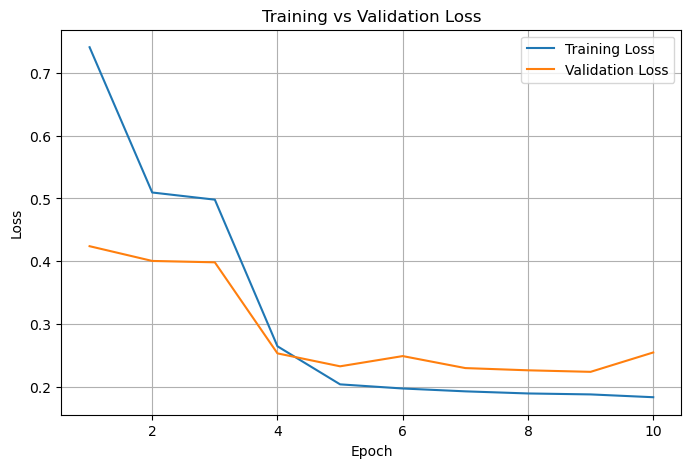

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Get prediction from model in evaluation mode to compare to ground truth

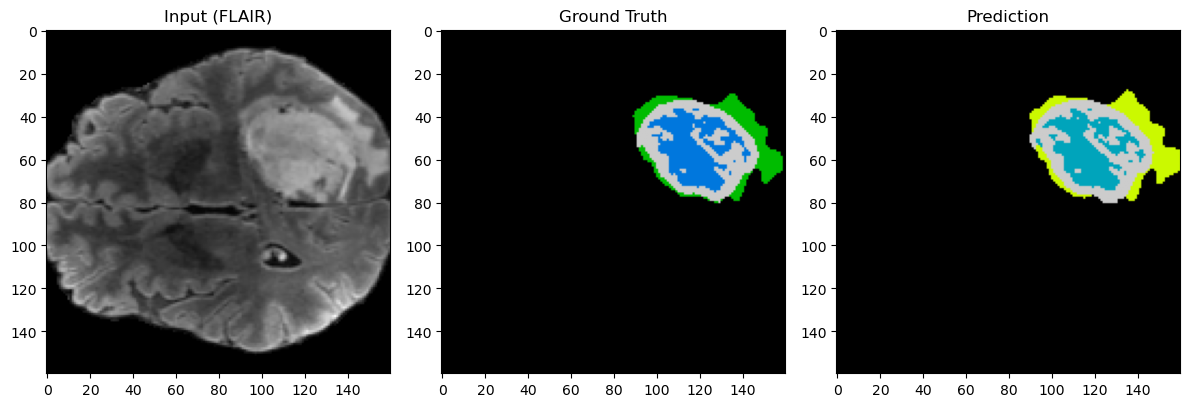

In [23]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(images[0, 0].cpu(), cmap='gray')
        plt.title("Input (FLAIR)")

        plt.subplot(1, 3, 2)
        plt.imshow(masks[0].cpu(), cmap='nipy_spectral')
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(preds[0], cmap='nipy_spectral')
        plt.title("Prediction")

        plt.tight_layout()
        plt.show()
        break

Evaulate the Model on Test Set

In [ ]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def evaluate_on_test(
    model,
    test_loader,
    device,
    num_classes: int = 4,
    ignore_index: int | None = None,   # set to 0 if you want to exclude background
    class_names: list[str] | None = None,
    remap_brats: bool = True,          # remap labels {0,1,2,4} -> {0,1,2,3}
):
    """
    Evaluate a segmentation model on a test set with pixel-level metrics.
    """

    model.eval()
    cm = torch.zeros((num_classes, num_classes), dtype=torch.long, device="cpu")

    for images, masks in test_loader:
        images = images.to(device=device, dtype=torch.float32)
        masks  = masks.to(device=device, dtype=torch.long)

        # BraTS remap if needed
        if remap_brats:
            masks = masks.clone()
            masks[masks == 4] = 3

        # forward
        logits = model(images)                # [B,C,H,W]
        preds  = torch.argmax(logits, dim=1)  # [B,H,W]

        # flatten
        t = masks.view(-1)
        p = preds.view(-1)

        if ignore_index is not None:
            valid = t != ignore_index
            t = t[valid]; p = p[valid]

        # CPU for bincount
        t_cpu = t.detach().to("cpu")
        p_cpu = p.detach().to("cpu")

        # safety check
        max_t = int(t_cpu.max()) if t_cpu.numel() else -1
        max_p = int(p_cpu.max()) if p_cpu.numel() else -1
        if max_t >= num_classes or max_p >= num_classes:
            raise ValueError(
                f"Label out of range: max_t={max_t}, max_p={max_p}, num_classes={num_classes}. "
                f"Check remapping or adjust num_classes."
            )

        cm += torch.bincount(
            (t_cpu * num_classes + p_cpu),
            minlength=num_classes * num_classes
        ).reshape(num_classes, num_classes)

    # metrics from confusion matrix 
    eps = 1e-9
    TP = cm.diag().to(torch.float64)
    FP = cm.sum(0).to(torch.float64) - TP
    FN = cm.sum(1).to(torch.float64) - TP

    # pixel accuracy
    overall_acc = (TP.sum() / cm.sum().clamp_min(1)).item()

    precision = (TP / (TP + FP + eps)).cpu().numpy()
    recall    = (TP / (TP + FN + eps)).cpu().numpy()
    f1        = (2 * precision * recall / (precision + recall + eps))
    dice      = (2 * TP / (2 * TP + FP + FN + eps)).cpu().numpy()
    iou       = (TP / (TP + FP + FN + eps)).cpu().numpy()

    # macro averages (exclude bg if requested)
    if ignore_index is not None:
        idx = [i for i in range(num_classes) if i != ignore_index]
    else:
        idx = list(range(num_classes))

    macro = {
        "macro_precision": float(precision[idx].mean()),
        "macro_recall":    float(recall[idx].mean()),
        "macro_f1":        float(f1[idx].mean()),
        "macro_dice":      float(dice[idx].mean()),
        "macro_iou":       float(iou[idx].mean()),
    }

    per_class = []
    for k in range(num_classes):
        per_class.append({
            "class": class_names[k] if class_names and k < len(class_names) else k,
            "precision": float(precision[k]),
            "recall":    float(recall[k]),
            "f1":        float(f1[k]),
            "dice":      float(dice[k]),
            "iou":       float(iou[k]),
        })

    return {
        "overall_accuracy": float(overall_acc),
        "per_class": per_class,
        **macro,
        "confusion_matrix": cm.cpu().numpy().tolist(),
    }
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

results = evaluate_on_test(
    model,
    test_loader,
    device,
    num_classes=4,               # {0,1,2,3} after remap
    ignore_index=0,              # exclude background from macro avg
    class_names=["bg", "edema", "non-enh", "enh"],
    remap_brats=True              # important if masks have label 4
)

print(f"\nOverall pixel accuracy: {results['overall_accuracy']:.4f}")
print(f"Macro Dice (excl bg):   {results['macro_dice']:.4f}")
print(f"Macro IoU  (excl bg):   {results['macro_iou']:.4f}")
for c in results["per_class"]:
    print(f"Class {c['class']}: Dice={c['dice']:.4f}, IoU={c['iou']:.4f}, "
          f"P={c['precision']:.4f}, R={c['recall']:.4f}, F1={c['f1']:.4f}")


Overall pixel accuracy: 0.8854
Macro Dice (excl bg):   0.8805
Macro IoU  (excl bg):   0.7908
Class bg: Dice=0.0000, IoU=0.0000, P=0.0000, R=0.0000, F1=0.0000
Class edema: Dice=0.8030, IoU=0.6709, P=0.8417, R=0.7678, F1=0.8030
Class non-enh: Dice=0.9302, IoU=0.8696, P=0.9568, R=0.9051, F1=0.9302
Class enh: Dice=0.9083, IoU=0.8319, P=0.9273, R=0.8900, F1=0.9083
